In [1]:
''' Creation: 2021.09.12
    Last update: 2021.09.20
    
    User specific paths definition
    
    '''

# Standard library imports
import os
from pathlib import Path

# 3rd party import
import pandas as pd

#Internal import 
import PVcharacterization_Utils as pv


# List of available bow data files
datafiles_list = pv.select_files()
#datafiles_list = list(datafiles_list)
#datafiles_list.sort()

list_files_descp = [pv.parse_filename(file) for file in datafiles_list]
    
df_files_descp  = pd.DataFrame(list_files_descp)

database_path = Path(os.path.dirname(datafiles_list[0])) / Path(pv.DATA_BASE_NAME)

pv.df2sqlite(df_files_descp, file=database_path, tbl_name=pv.DATA_BASE_TABLE)

print('Datafiles list built')

Datafiles list built


In [2]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    
    '''
# Standard library imports
import os

#Internal import 
import PVcharacterization_Utils as pv

pow_select = [200,400,600,800,1000,2000,4000]
name_select = ["DINERGY3272023326035","JINERGY3272023326035"]
time_select = ["T0", "T1", "T2"]

querries = pv.sieve_files(pow_select,time_select,name_select,database_path)

df_files_descp_copy = df_files_descp

df_files_descp_copy.index = [os.path.basename(x).split('.')[0] for x in df_files_descp_copy['file'].tolist()]
df_files_descp_copy = df_files_descp_copy.loc[:,['power','time','name'] ]

res = [pv.data_parsing(querry,parse_all=False).meta_data for querry in querries]
df_meta = pd.DataFrame.from_dict(res)
df_meta.index = df_meta['ID']
df_meta = df_meta.loc[:,pv.USED_COLS]

df_meta = pd.merge(df_meta,df_files_descp_copy,left_index=True, right_index=True)
df_meta

,Title,Voc,Isc,Rseries,Rshunt,Pmax,Vpm,Ipm,Fill Factor,power,time,name
ID,,,,,,,,,,,,
DINERGY3272023326035_0200W_T0,HET JNHM72 6x12 M2 0200W,50.5082,1.827,1.95841,1593.92,72.2867,42.5857,1.69744,0.78335,200,T0,DINERGY3272023326035
DINERGY3272023326035_0200W_T1,HET JNHM72 6x12 M2 0200W,50.6780,1.82484,1.87985,1874.07,72.5313,42.7868,1.69517,0.78429,200,T1,DINERGY3272023326035
DINERGY3272023326035_0200W_T2,HET DNHM72 6x12 M2 0200W,50.3452,1.79790,2.09313,875.055,71.105,42.5312,1.67182,0.78555,200,T2,DINERGY3272023326035
DINERGY3272023326035_0400W_T0,HET JNHM72 6x12 M2 0400W,51.8321,3.61464,1.05142,703.805,148.082,44.0490,3.36175,0.79038,400,T0,DINERGY3272023326035
DINERGY3272023326035_0400W_T1,HET JNHM72 6x12 M2 0400W,51.9387,3.61127,0.96906,795.822,148.774,44.2281,3.36379,0.79319,400,T1,DINERGY3272023326035
DINERGY3272023326035_0400W_T2,HET JNHM72 6x12 M2 0400W,51.6677,3.55743,1.01058,827.496,145.590,43.7553,3.32737,0.79209,400,T2,DINERGY3272023326035
DINERGY3272023326035_0600W_T0,HET JNHM72 6x10 M2 0600W,52.4938,5.39540,0.68749,632.893,223.513,44.4636,5.02687,0.78917,600,T0,DINERGY3272023326035
DINERGY3272023326035_0600W_T1,HET JNHM72 6x10 M2 0600W,52.6060,5.39036,0.72844,714.475,224.548,44.6874,5.02485,0.79187,600,T1,DINERGY3272023326035
DINERGY3272023326035_0600W_T2,HET JNHM72 6x10 M2 0600W,52.3567,5.30642,0.80821,913.975,219.481,44.0355,4.98419,0.78999,600,T2,DINERGY3272023326035


In [3]:
df_meta['tech'] = df_meta['Title'].apply(lambda x:x.split(' ')[0] )

In [4]:
df_meta

,Title,Voc,Isc,Rseries,Rshunt,Pmax,Vpm,Ipm,Fill Factor,power,time,name,tech
ID,,,,,,,,,,,,,
DINERGY3272023326035_0200W_T0,HET JNHM72 6x12 M2 0200W,50.5082,1.827,1.95841,1593.92,72.2867,42.5857,1.69744,0.78335,200,T0,DINERGY3272023326035,HET
DINERGY3272023326035_0200W_T1,HET JNHM72 6x12 M2 0200W,50.6780,1.82484,1.87985,1874.07,72.5313,42.7868,1.69517,0.78429,200,T1,DINERGY3272023326035,HET
DINERGY3272023326035_0200W_T2,HET DNHM72 6x12 M2 0200W,50.3452,1.79790,2.09313,875.055,71.105,42.5312,1.67182,0.78555,200,T2,DINERGY3272023326035,HET
DINERGY3272023326035_0400W_T0,HET JNHM72 6x12 M2 0400W,51.8321,3.61464,1.05142,703.805,148.082,44.0490,3.36175,0.79038,400,T0,DINERGY3272023326035,HET
DINERGY3272023326035_0400W_T1,HET JNHM72 6x12 M2 0400W,51.9387,3.61127,0.96906,795.822,148.774,44.2281,3.36379,0.79319,400,T1,DINERGY3272023326035,HET
DINERGY3272023326035_0400W_T2,HET JNHM72 6x12 M2 0400W,51.6677,3.55743,1.01058,827.496,145.590,43.7553,3.32737,0.79209,400,T2,DINERGY3272023326035,HET
DINERGY3272023326035_0600W_T0,HET JNHM72 6x10 M2 0600W,52.4938,5.39540,0.68749,632.893,223.513,44.4636,5.02687,0.78917,600,T0,DINERGY3272023326035,HET
DINERGY3272023326035_0600W_T1,HET JNHM72 6x10 M2 0600W,52.6060,5.39036,0.72844,714.475,224.548,44.6874,5.02485,0.79187,600,T1,DINERGY3272023326035,HET
DINERGY3272023326035_0600W_T2,HET JNHM72 6x10 M2 0600W,52.3567,5.30642,0.80821,913.975,219.481,44.0355,4.98419,0.78999,600,T2,DINERGY3272023326035,HET


In [5]:
def plot_diff_param(params, df_meta):
    
    '''Plots for different experiments and for different parameters the relative 
    evolution (in %) of the parameters vs power
    
      ID                          Voc         Isc   Rseries   power time                                                         
   JINERGY3272023326035_0200W_T0  50.5082    1.827  1.95841     200   T0  
   JINERGY3272023326035_0200W_T1  50.6780  1.82484  1.87985     200   T1   
   JINERGY3272023326035_0200W_T2  50.3452  1.79790  2.09313     200   T2  
   JINERGY3272023326035_0400W_T0  51.8321  3.61464  1.05142     400   T0 

    '''

    # Standard library imports
    from itertools import combinations

    # 3rd party import
    import matplotlib.pyplot as plt
    import numpy as np
    
    #color = ["#8F3E3A", "#8F5B3A", "#8F7B3A", "#7B8F3A", "#458F3A",] # "#3A8F72", "#433A8F" ]
    color = ['#0000A0','#1569C7','#78f89d','#FFEB3B','#E64A19']
    marker = ["o", "v", ">", "<", "s", "p"]
    dic_ylim = {"Rseries":[-30, 30],
                "Rshunt":[-30, 30],
                "Voc":[-3.2, 1.6],
                "Isc":[-3.2, 1.6],
                "Pmax":[-3.2, 1.6],
                "Fill Factor":[-3.2, 1.6]}

    pow_list = sorted(list(set(df_meta["power"].tolist())))
    pow_add_nbr = 2
    pow_median = (min(pow_list) + max(pow_list)) / 2
    pow_add = (max(pow_list) - min(pow_list)) / 2
    pow_min, pow_max = (
        min(pow_list) - pow_add_nbr * pow_add,
        max(pow_list) + pow_add_nbr * pow_add,
    )

    nbr_time = len(set(df_meta["time"].tolist()))
    assert nbr_time > 1, "not enough time measurements. Should be greeter than 1"
    
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(
        len(params), int(nbr_time * (nbr_time - 1) / 2), hspace=0, wspace=0
    )
    ax = gs.subplots(sharex="col", sharey="row")


    list_exp = list(set(df_meta["name"]))

    delta_curve = 0
    for idx_exp, exp in enumerate(list_exp): # Loop on the experiments
        if idx_exp == 1:  delta_curve = -0.2
        
        df_exp = df_meta.query("name == @exp")

        # split df_exp into a dic keyed by time (T0,T1,...). The values are dataframe df_exp
        # with column time=T0,T1,...
        dic_time = {}
        set_times = set(df_exp["time"].tolist())
        for time in set_times:
            dic_time[time] = df_exp.loc[df_exp["time"] == time, :]

        list_t = sorted(list(set(df_exp["time"].tolist())))

        for idx_param, param in enumerate(params): # Loop on the parameter
            dic_time_cp = {}

            for time in combinations(list_t, 2): # Loop on time difference
                val = np.array(dic_time[time[1]][param].astype(float).tolist())
                ref = np.array(dic_time[time[0]][param].astype(float).tolist())
                delta = 100 * (val - ref) / ref
                dic_time_cp[time[1] + "-" + time[0]] = dic_time[time[1]].copy()
                dic_time_cp[time[1] + "-" + time[0]]["Delta_" + param] = delta

            list_times_diff = sorted(dic_time_cp.keys())
            if len(params) == 1:
                for idx_time, key in enumerate(list_times_diff):
                    #ax[idx_param, idx_time].scatter(
                            #dic_time_cp[key]["power"],
                            #dic_time_cp[key]["Delta_" + param],
                            #c=color,
                            #marker=marker[idx_exp]
                        #)
                    ax[idx_time].scatter(
                        dic_time_cp[key]["power"],
                        np.array(dic_time_cp[key]["Delta_" + param])+delta_curve,
                        c=color,
                        marker=marker[idx_exp]
                    )
                    ax[idx_time].axhline(y=0, color="red", linestyle="--")
                    if idx_param == 0:
                        ax[idx_time].set_title(key)
                    ax[idx_time].set_xlabel("Power ($W/{m^2}$)")
                    if idx_time == 0:
                        ax[idx_time].set_ylabel("$\Delta$ " + param + " (%)")
                    ax[idx_time].tick_params(axis="x", rotation=90)
                    ax[idx_time].set_xticks(pow_list, minor=False)
                    ax[idx_time].set_xticklabels(pow_list, fontsize=12)
                    ax[idx_time].set_xlim([pow_min, pow_max])
                    ax[idx_time].set_ylim(dic_ylim.get(param,[-3.2, 1.6]))
                    for axis in ["top", "bottom", "left", "right"]:
                        ax[idx_time].spines[axis].set_linewidth(2)
            else:
                for idx_time, key in enumerate(list_times_diff):
                    #ax[idx_param, idx_time].scatter(
                            #dic_time_cp[key]["power"],
                            #dic_time_cp[key]["Delta_" + param],
                            #c=color,
                            #marker=marker[idx_exp]
                        #)
                    ax[idx_param, idx_time].scatter(
                        dic_time_cp[key]["power"],
                        np.array(dic_time_cp[key]["Delta_" + param])+delta_curve,
                        c=color,
                        marker=marker[idx_exp]
                    )
                    ax[idx_param, idx_time].axhline(y=0, color="red", linestyle="--")
                    if idx_param == 0:
                        ax[idx_param, idx_time].set_title(key)
                    ax[idx_param, idx_time].set_xlabel("Power ($W/{m^2}$)")
                    if idx_time == 0:
                        ax[idx_param, idx_time].set_ylabel("$\Delta$ " + param + " (%)")
                    ax[idx_param, idx_time].tick_params(axis="x", rotation=90)
                    ax[idx_param, idx_time].set_xticks(pow_list, minor=False)
                    ax[idx_param, idx_time].set_xticklabels(pow_list, fontsize=12)
                    ax[idx_param, idx_time].set_xlim([pow_min, pow_max])
                    ax[idx_param, idx_time].set_ylim(dic_ylim.get(param,[-3.2, 1.6]))
                    for axis in ["top", "bottom", "left", "right"]:
                        ax[idx_param, idx_time].spines[axis].set_linewidth(2)

    title = chr(9679) + " " + list_exp[0]
    if len(list_exp) ==2 : title = title + ', ' + chr(9660) + " " + list_exp[1]
    fig.suptitle(title, fontsize=13)
    fig.subplots_adjust(top=0.95)

WARNING parameter trarmiz will be ignored
WARNING parameter bidon will be ignored


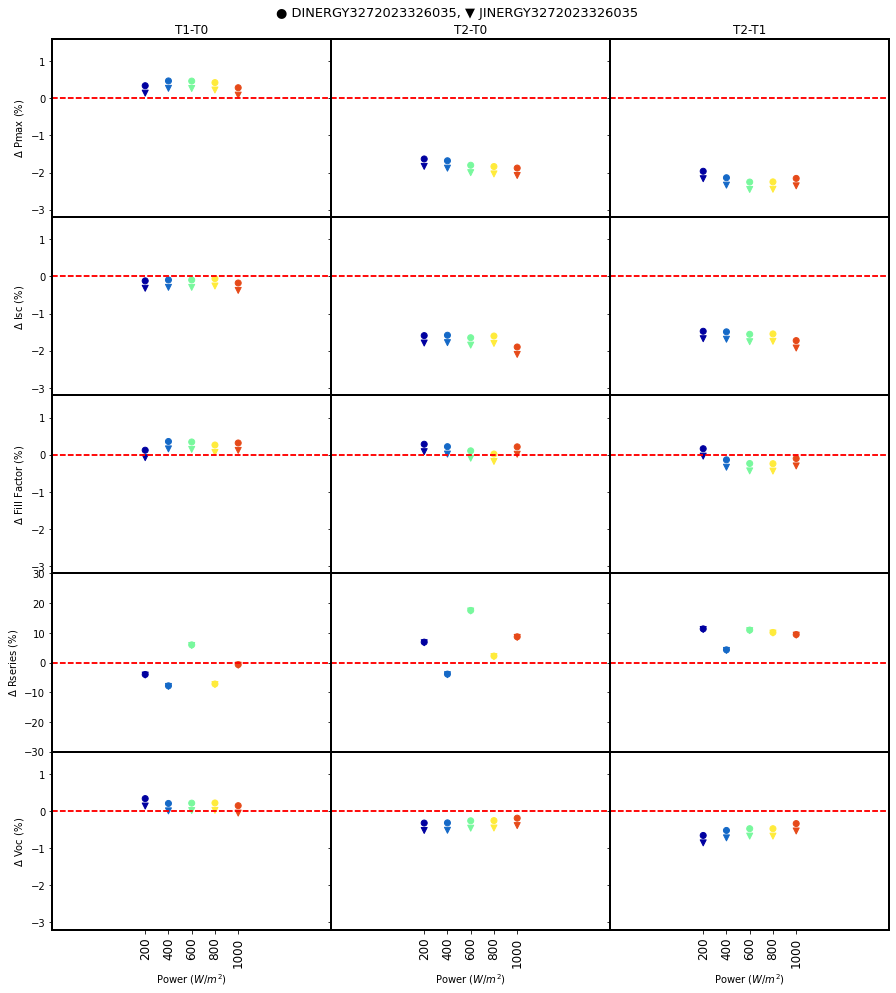

In [6]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    Plotting of parameters evolution.
    
    '''

#Internal import 
import PVcharacterization_Utils as pv

params = ['Pmax','Voc','Isc','Fill Factor','Rseries','bidon','trarmiz']

unkown_params = set(params).difference(set(pv.USED_COLS))
for unknow_param in unkown_params:
    print(f'WARNING parameter {unknow_param} will be ignored')
    
params = set(pv.USED_COLS).intersection(set(params)) 

plot_diff_param(params,df_meta)


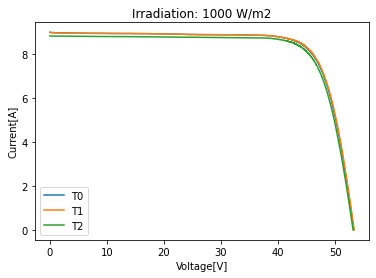

In [14]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    Plotting of I/V curves.
    
    '''

# 3rd party import
import matplotlib.pyplot as plt

#Internal import 
import PVcharacterization_Utils as pv

pow_select = [1000]
name_select = ["JINERGY3272023326035",]
time_select = ["T0","T1","T2"]

querries = pv.sieve_files(pow_select,time_select,name_select,database_path)

for i, res in enumerate([pv.data_parsing(querry).IV0 for querry in querries]):
    plt.plot(res['Voltage'],res['Current'],label=time_select[i])
    plt.xlabel(res.columns[0] +'[V]')
    plt.ylabel(res.columns[1] +'[A]')
    plt.title(f'Irradiation: {str(pow_select[0])} {pv.PARAM_UNIT_DIC["IrrCorr"]}')
    
plt.legend()
plt.show()

    

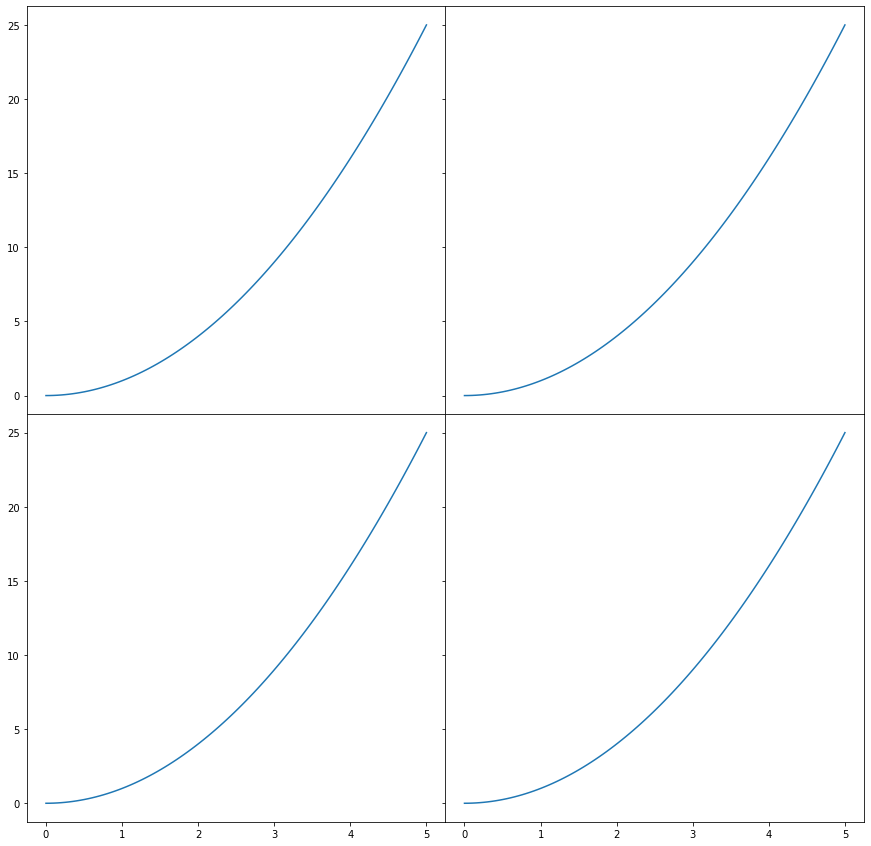

In [15]:
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(
        2, 2, hspace=0, wspace=0
    )
x = np.linspace(0,5,100)
ax = gs.subplots(sharex="col", sharey="row")
for icol in range(2):
    for irow in range(2):
        ax[icol,irow].plot(x,x**2)

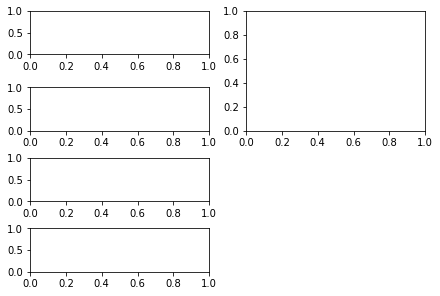

In [20]:
# Implementation of matplotlib function
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
  
  
fig = plt.figure(constrained_layout = True)
gs = fig.add_gridspec(4, 2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

ax3 = fig.add_subplot(gs[2,0])

ax4 = fig.add_subplot(gs[3,0])

ax5 = fig.add_subplot(gs[0:2,1])

